# Strategic Optimization of Bike Supply and Demand During Commuting Hours 
: San Francisco Bike Share Analysis

## Load packages

In [ ]:
import pandas as pd          
import numpy as np           
import matplotlib.pyplot as plt  
import seaborn as sns
import  folium 
import mysql.connector      

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
#sns.set(style='whitegrid')

## Connect MySQL with Python

In [ ]:
# Connect MySQL with Python
conn_local = mysql.connector.connect(
    host="localhost",         
    user="root",              
    password="1234",          
    database="bike"
)   

cursor = conn_local.cursor(buffered=True)

In [66]:
query = '''SELECT * FROM station'''
station = pd.read_sql_query(query, conn_local)
station 

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/178549218.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  station = pd.read_sql_query(query, conn_local)


,id,name,lat,longitude,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.3297,-121.902,27,San Jose,2013-08-06
1,3,San Jose Civic Center,37.3307,-121.889,15,San Jose,2013-08-05
2,4,Santa Clara at Almaden,37.3340,-121.895,11,San Jose,2013-08-06
3,5,Adobe on Almaden,37.3314,-121.893,19,San Jose,2013-08-05
4,6,San Pedro Square,37.3367,-121.894,15,San Jose,2013-08-07
...,...,...,...,...,...,...,...
65,77,Market at Sansome,37.7896,-122.401,27,San Francisco,2013-08-25
66,80,Santa Clara County Civic Center,37.3526,-121.906,15,San Jose,2013-12-31
67,82,Broadway St at Battery St,37.7985,-122.401,15,San Francisco,2014-01-22
68,83,Mezes Park,37.4913,-122.236,15,Redwood City,2014-02-20


In [107]:
# Stations are divided into 5 regions: San Jose, Redwood City, Mountain View, Palo Alto, and San Francisco
# Focused on San Francisco only to analyze commuting routes

# Created map centered in San Francisco
# sf_center = [37.7749, -122.4194]
# m = folium.Map(location=sf_center, zoom_start=13)

# # Add marker
# for _, row in station.iterrows():
#     folium.Marker(
#         location=[row['lat'], row['longitude']],
#         popup=f"<b>{row['name']}</b><br>Installed: {row['installation_date']}",
#         icon=folium.Icon(color='red', icon='bicycle', prefix='fa')
#     ).add_to(m)

# m

In [74]:
# High usage on weekdays (Monday to Friday), noticeable drop on weekends (Saturday and Sunday)
query = '''SELECT 
  DAYNAME(t.start_date) AS day_of_week,
  COUNT(*) AS total_rides,
  SUM(CASE 
        WHEN t.start_station_name != t.end_station_name THEN 1 
        ELSE 0 
      END) AS diff_station_rides,
  COUNT(*) - SUM(CASE 
        WHEN t.start_station_name != t.end_station_name THEN 1 
        ELSE 0 
      END) AS same_station_rides
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco' 
  AND duration > 120
GROUP BY day_of_week
ORDER BY FIELD(day_of_week, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday');
'''
result1 = pd.read_sql_query(query, conn_local)
result1

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/2838705307.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result1 = pd.read_sql_query(query, conn_local)


,day_of_week,total_rides,diff_station_rides,same_station_rides
0,Monday,100173,98466.0,1707.0
1,Tuesday,105892,104350.0,1542.0
2,Wednesday,104054,102508.0,1546.0
3,Thursday,103149,101337.0,1812.0
4,Friday,94041,92088.0,1953.0
5,Saturday,35308,32710.0,2598.0
6,Sunday,29558,26999.0,2559.0


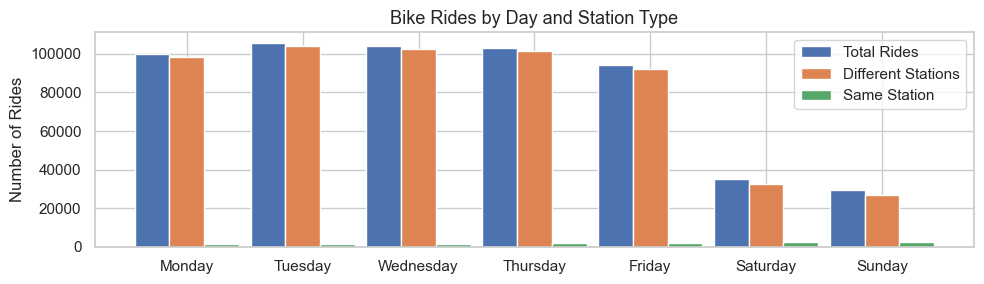

In [157]:
bar_width = 0.30
x = np.arange(len(result1['day_of_week']))

# 플롯 그리기
plt.figure(figsize=(10, 3))
plt.bar(x - bar_width, result1['total_rides'], width=bar_width, label='Total Rides')
plt.bar(x, result1['diff_station_rides'], width=bar_width, label='Different Stations')
plt.bar(x + bar_width, result1['same_station_rides'], width=bar_width, label='Same Station')

# x축 라벨 및 제목
plt.xticks(x, result1['day_of_week'])
plt.ylabel('Number of Rides')
plt.title('Bike Rides by Day and Station Type', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.show()

## Definition of Cummuting time

### Popular time On weekdays

In [ ]:
# Origin station ≠ destination station
# Day of the week: Monday to Friday (weekday)

# Popular time on weekdays : 8, 17, 9, 18, 16 
query = '''SELECT HOUR(start_date) AS hour, count(*) as trip_count 
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco'
	AND start_station_name != end_station_name
    AND DAYNAME(t.start_date) in ('Monday', 'Tuesday' ,'Wednesday', 'Thursday', 'Friday')
GROUP BY HOUR(start_date)                                 
ORDER BY trip_count DESC; '''
result2 = pd.read_sql_query(query, conn_local)
result2[:5]

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/2698591327.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result2 = pd.read_sql_query(query, conn_local)


,hour,trip_count
0,8,75688
1,17,66582
2,9,51917
3,18,45433
4,16,43728


In [ ]:
# Day of the week: Monday to Friday (weekday)

# Popular time on weekdays : 8, 17, 9, 18, 16 

query = '''SELECT HOUR(start_date) AS hour, count(*) as trip_count 
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco'
    AND DAYNAME(t.start_date) in ('Monday', 'Tuesday' ,'Wednesday', 'Thursday', 'Friday')
GROUP BY HOUR(start_date)                                 
ORDER BY trip_count DESC; '''
result2 = pd.read_sql_query(query, conn_local)
result2[:5]

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/3116936639.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result2 = pd.read_sql_query(query, conn_local)


,hour,trip_count
0,8,76093
1,17,67217
2,9,52418
3,18,45961
4,16,44550


In [139]:
query = '''SELECT HOUR(start_date) AS hour, count(*) as trip_count 
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco'
	AND start_station_name = end_station_name
    AND DAYNAME(t.start_date) in ('Monday', 'Tuesday' ,'Wednesday', 'Thursday', 'Friday')
GROUP BY HOUR(start_date)                                 
ORDER BY trip_count DESC; '''

result10 = pd.read_sql_query(query, conn_local)
result10[:5]

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/2781239292.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result10 = pd.read_sql_query(query, conn_local)


,hour,trip_count
0,12,1028
1,13,932
2,14,883
3,16,822
4,15,819


In [101]:
# Sorted out unnecesarry duration
query = '''SELECT * 
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco'
	AND start_station_name != end_station_name
    AND HOUR(t.start_date) in (8, 17, 9, 18, 16)
    AND DAYNAME(t.start_date) in ('Monday', 'Tuesday' ,'Wednesday', 'Thursday', 'Friday');'''

result3 = pd.read_sql_query(query, conn_local)
result3.head() #len(result3) #283348

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/2788380435.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result3 = pd.read_sql_query(query, conn_local)


,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subcribtion_type,zip_code,date,id,name,lat,longitude,dock_count,city,installation_date
0,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
1,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
2,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
3,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
4,4080,764,2013-08-29 09:36:00,South Van Ness at Market,66,2013-08-29 09:49:00,San Francisco Caltrain 2 (330 Townsend),69,315,Subscriber,94117,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23


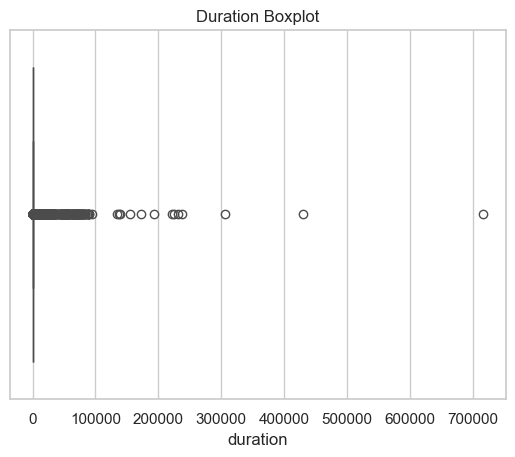

In [ ]:
# removed outliers
sns.boxplot(x='duration', data=result3)
plt.title('Duration Boxplot')
plt.show()

In [ ]:
print(len(result3[result3['duration']>100000])) #13
print(len(result3[(result3['duration'] > 5000) & (result3['duration'] < 100000)])) # 1212 (0.5%)
print(len(result3[(result3['duration'] > 3500) & (result3['duration'] < 5000)])) #368
#3600 over : 1562 (0.05 % )#100000 : 13 (like tow hour )

13
1212
368


In [120]:
result3 = result3[result3['duration']<100000]

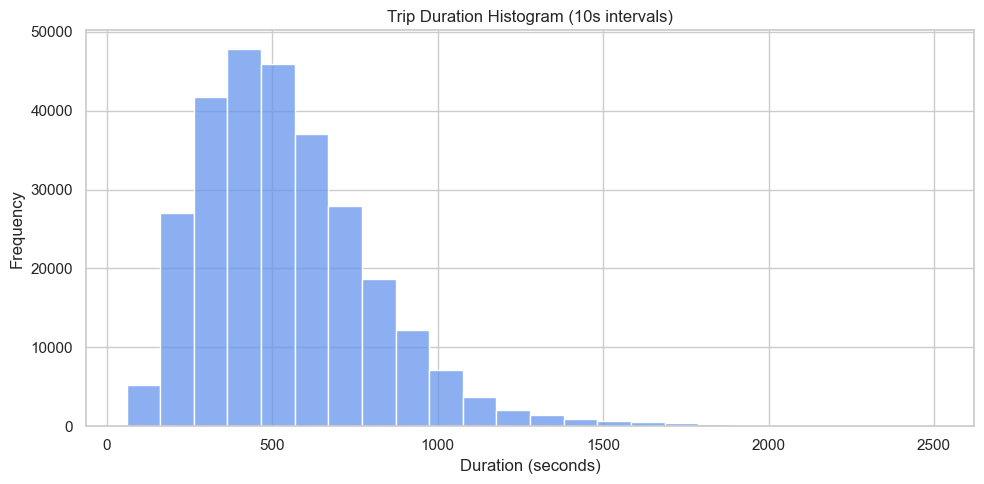

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(data=result3[result3['duration']<2500], x='duration', binwidth=100, color='cornflowerblue')

plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram (10s intervals)')
plt.tight_layout()
plt.show()

#Around 33 mins(2000 sec) meaningful data analysis range 
#At but other cases are smaller so we do firstly contain all the data and sorted out unnecessary one

## Popular Route on Weekdays

In [123]:
query = '''
SELECT 
  HOUR(t.start_date) AS start_hour, 
  HOUR(t.end_date) AS end_hour, 
  s_start.id AS start_station_id, 
  s_end.id AS end_station_id,
  t.start_station_name, 
  t.end_station_name, 
  COUNT(*) AS number
FROM trip t
JOIN station s_start ON s_start.name = t.start_station_name
JOIN station s_end ON s_end.name = t.end_station_name
WHERE s_start.city = 'San Francisco' 
  AND t.start_station_name != t.end_station_name
  AND DAYNAME(t.start_date) IN ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
  AND HOUR(t.start_date) IN (8, 9)
GROUP BY 
  start_hour, 
  end_hour, 
  s_start.id, 
  s_end.id,
  t.start_station_name, 
  t.end_station_name
ORDER BY number DESC
LIMIT 5;'''

result4 = pd.read_sql_query(query, conn_local)
result4

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/4121554273.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result4 = pd.read_sql_query(query, conn_local)


,start_hour,end_hour,start_station_id,end_station_id,start_station_name,end_station_name,number
0,8,8,50,61,Harry Bridges Plaza (Ferry Building),2nd at Townsend,1341
1,9,9,69,65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,1018
2,9,9,77,64,Market at Sansome,2nd at South Park,991
3,9,9,74,61,Steuart at Market,2nd at Townsend,910
4,8,8,69,65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,886


## Average demand, available bikes, and demand-supply gap by departure station during commuting hours (8 AM and 9 AM)
Insight:

- At Harry Bridges Plaza (Ferry Building), the demand at 8 AM is approximately 14 bikes.
- However, the average number of bikes docked at that time is only 11, indicating a shortage of more than 2 bikes on average.
- → Suggest issuing shortage alerts and sourcing demand from nearby stations when demand exceeds 14–17 bikes.



In [125]:
query = '''SELECT 
    s.id AS station_id,
    s.name AS station_name,
    demand.hour,
    AVG(demand.trip_count) AS avg_demand,
    AVG(supply.avg_bike_available) AS avg_available,
    AVG(supply.avg_bike_available - demand.trip_count) AS avg_surplus_gap
FROM
    (SELECT 
        start_station_name,
        HOUR(start_date) AS hour,
        DATE(start_date) AS date,
        COUNT(*) AS trip_count
    FROM trip
    WHERE DAYOFWEEK(start_date) BETWEEN 2 AND 6
    GROUP BY start_station_name, DATE(start_date), HOUR(start_date)) AS demand ##여기는 duration이 작은거나, 같은것만 표시해서는 안됨. 왜냐면 다 출발은 하는거
JOIN station s ON s.name = demand.start_station_name
LEFT JOIN
    (SELECT 
        station_id,
        HOUR(time) AS hour,
        DATE(time) AS date,
        AVG(bike_available) AS avg_bike_available
    FROM status
    WHERE DAYOFWEEK(time) BETWEEN 2 AND 6
    GROUP BY station_id, DATE(time), HOUR(time)) AS supply
ON s.id = supply.station_id AND demand.hour = supply.hour AND demand.date = supply.date
GROUP BY s.id, s.name, demand.hour
HAVING station_name in ( select name from station where city = 'San Francisco') and hour in (8, 9)
ORDER BY station_id;'''

In [130]:
result5 = pd.read_sql_query(query, conn_local)
result5[result5['station_name']== 'Harry Bridges Plaza (Ferry Building)']

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/1330552705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result5 = pd.read_sql_query(query, conn_local)


,station_id,station_name,hour,avg_demand,avg_available,avg_surplus_gap
16,50,Harry Bridges Plaza (Ferry Building),8,14.0432,11.960630,-2.064961
17,50,Harry Bridges Plaza (Ferry Building),9,5.1760,6.570281,1.383534


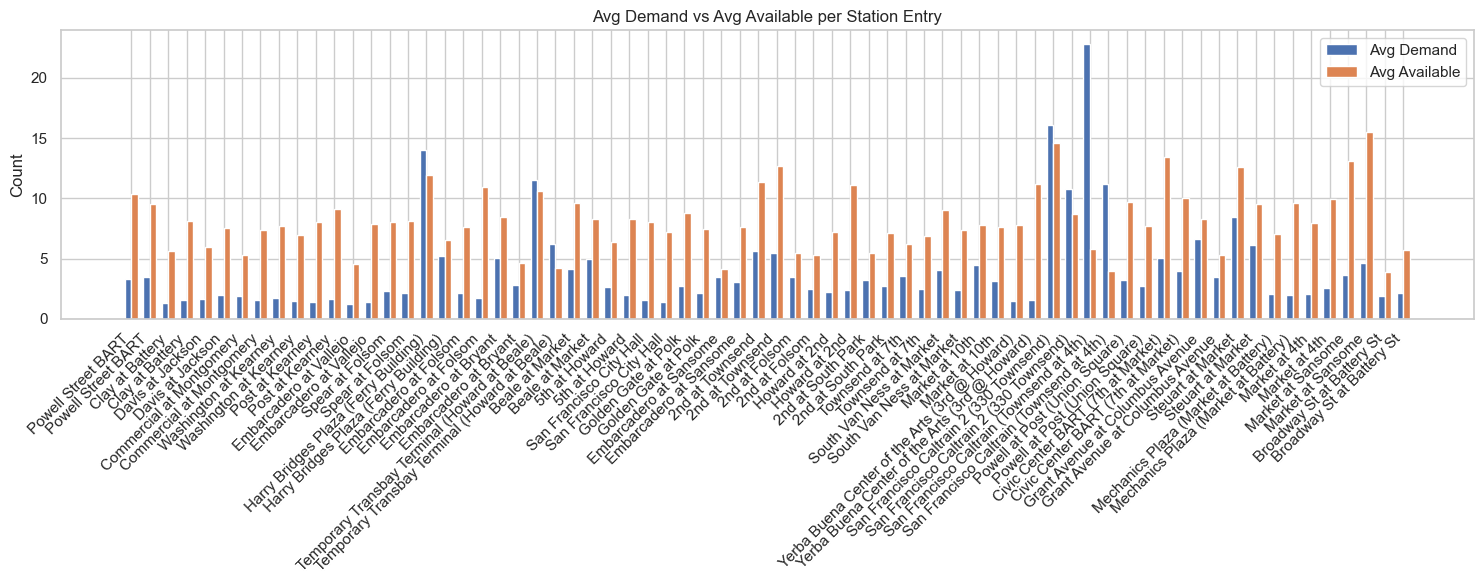

In [ ]:
#- 파란색 그래프 >  노란색 그래프일 경우 수요에 비해 공급이 부족한 상태
# - 인기루트에 포함 또는 포함되지 않더라도 적정 재고 유지를 해야함
x = np.arange(len(result5))  # 각 행별 x 위치
width = 0.35  # 막대 폭

fig, ax = plt.subplots(figsize=(15,6))
bar1 = ax.bar(x - width/2, result5['avg_demand'], width, label='Avg Demand')
bar2 = ax.bar(x + width/2, result5['avg_available'], width, label='Avg Available')

# x축 레이블에 station_name 사용, 45도 회전으로 겹침 최소화
ax.set_xticks(x)
ax.set_xticklabels(result5['station_name'], rotation=45, ha='right')

ax.set_ylabel('Count')
ax.set_title('Avg Demand vs Avg Available per Station Entry')
ax.legend()

plt.tight_layout()
plt.show()

## 5-2. Identifying nearby bike rental stations within a 1 km radius of popular stations
Insight:

Steuart at Market: Located approximately 100 meters away, making it a walkable distance.
According to the table above, there is an average surplus of 4 bikes at 8 AM.
→ Suggest utilizing nearby station alerts to enable distributed operations.

Davis at Jackson: The table indicates an average rental demand of 2 rides around 8 AM,
with a surplus of 4 to 5 bikes.
→ Monitor nearby inventory within 1 km and quickly reallocate bikes as needed.

## 5-2. 인기 정류장의 반경 1km내의 자전거대요소 구하기

- 인사이트:
  - Steuart at Market : 약 100m 거리이므로 걸어서 이동가능한 정류장, 바로 상단의 표에 따르면 8시에 약 4대의 재고가 발생 -> 근거리내 자전거 대여소 알람을 통해 분산운영
  - Davis at Jackson : 상단의 표에 따르면 8시 경 약 2건의 대여가 평균 대여량, 재고는 약 4개, 5개정도 발생 -> 즉 1km 내의 근거리 재고를 파악하여 빠르게 조달하기

In [132]:
query = ''' SELECT id, name, lat, longitude,
    (6371 * acos(
        cos(radians(37.7954)) * cos(radians(lat)) * 
        cos(radians(longitude) - radians(-122.394)) + 
        sin(radians(37.7954)) * sin(radians(lat))
    )) AS distance_km
FROM station
HAVING distance_km < 1
ORDER BY distance_km;'''

result6 = pd.read_sql_query(query, conn_local)
result6 


/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/1068699058.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result6 = pd.read_sql_query(query, conn_local)


,id,name,lat,longitude,distance_km
0,50,Harry Bridges Plaza (Ferry Building),37.7954,-122.394,0.017881
1,74,Steuart at Market,37.7941,-122.394,0.145173
2,42,Davis at Jackson,37.7973,-122.398,0.442375
3,56,Beale at Market,37.7923,-122.397,0.442880
4,51,Embarcadero at Folsom,37.7915,-122.391,0.509081
5,41,Clay at Battery,37.7950,-122.400,0.526518
6,55,Temporary Transbay Terminal (Howard at Beale),37.7898,-122.395,0.630058
7,75,Mechanics Plaza (Market at Battery),37.7913,-122.399,0.635929
8,49,Spear at Folsom,37.7903,-122.391,0.639111
9,48,Embarcadero at Vallejo,37.8000,-122.399,0.643572


In [134]:
# 기준점 좌표
center_lat, center_lon = 37.7954, -122.394

# 지도 생성 (기준점 중심, 적당한 zoom 레벨)
m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# 기준점 표시 (예: 파란색 마커)
folium.Marker(
    location=[center_lat, center_lon],
    popup='Center Point',
    icon=folium.Icon(color='blue')
).add_to(m)

# 각 스테이션 표시
for idx, row in result6.iterrows():
    color = 'red' if row['distance_km'] < 1 else 'gray'  # 1km 이내는 빨간색, 아니면 회색
    folium.CircleMarker(
        location=[row['lat'], row['longitude']],
        radius=7,
        popup=f"{row['name']} ({row['distance_km']:.2f} km)",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# 기준점에서 반경 1km 원 그리기
folium.Circle(
    location=[center_lat, center_lon],
    radius=1000,  # 미터 단위
    color='blue',
    fill=False
).add_to(m)

# 지도를 파일로 저장하거나 바로 노트북에서 표시 가능
m


## Average arrivals, remaining bikes, and available docks at destination stations during commuting hours (8 AM and 9 AM)
Insight:

Available docks: Each station has a fixed number of docking slots.
For example, if a station has 19 docks but 25 bikes are arriving, 6 bikes cannot be docked.
→ Recommend redistributing traffic before reaching full capacity and guiding users to nearby stations.

2nd at Townsend: An average of 8 bikes arrive, and typically 12 to 14 bikes are already parked.
With a capacity of 13 to 15 bikes, care should be taken to avoid exceeding dock availability.

## 5-3. 출근시간(8시, 9시) 도착지 station별 평균 도착, 평균 기존 잔여 대수, 여유 도킹 대수

- 인사이트:
  - 여유 도킹 대수 : 각 station별로 도킹대수가 정해져 있음. 19개의 도킹이 가능하다면 25대가 도착한다면 6개는 도킹할 수 없음
  -> 도킹대수가 특정 지점에 도달하기 전에 분산, 주변 정류장으로 안내
  - 2nd at Townsend : 평균 8대 도착하며 보통 12대~14 정도 주차됨. 15~13대 수용 가능하므로 그 이상 도착하지 않도록 주의

In [135]:
query = '''SELECT 
    s.id AS station_id,
    s.name AS station_name,
    s.dock_count AS dock,
    demand.hour,
    AVG(demand.trip_count) AS avg_arrival,
    AVG(supply.avg_bike_available) AS avg_available_bikes,  
    (s.dock_count - AVG(supply.avg_bike_available)) AS avg_capacity
FROM
    (SELECT 
        end_station_name,
        HOUR(end_date) AS hour,
        DATE(end_date) AS date,
        COUNT(*) AS trip_count
    FROM trip
    WHERE DAYOFWEEK(end_date) BETWEEN 2 AND 6
    GROUP BY end_station_name, DATE(end_date), HOUR(end_date)) AS demand
JOIN station s ON s.name = demand.end_station_name
LEFT JOIN
    (SELECT 
        station_id,
        HOUR(time) AS hour,
        DATE(time) AS date,
        AVG(bike_available) AS avg_bike_available
    FROM status
    WHERE DAYOFWEEK(time) BETWEEN 2 AND 6
    GROUP BY station_id, DATE(time), HOUR(time)) AS supply
ON s.id = supply.station_id AND demand.hour = supply.hour AND demand.date = supply.date
GROUP BY s.id, s.name, s.dock_count, demand.hour
HAVING station_name IN (
    SELECT name FROM station WHERE city = 'San Francisco'
) AND hour in (8, 9, 10)
ORDER BY station_id;  '''

result7 = pd.read_sql_query(query, conn_local)
result7 

/var/folders/1l/6dhcmnn51hj3w9sg068lv3_r0000gn/T/ipykernel_2496/3259242347.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result7 = pd.read_sql_query(query, conn_local)


,station_id,station_name,dock,hour,avg_arrival,avg_available_bikes,avg_capacity
0,39,Powell Street BART,19,8,2.7426,10.362473,8.637527
1,39,Powell Street BART,19,9,3.2371,9.425620,9.574380
2,39,Powell Street BART,19,10,1.9435,9.282258,9.717742
3,41,Clay at Battery,15,8,3.9712,5.727273,9.272727
4,41,Clay at Battery,15,9,3.0438,8.119497,6.880503
...,...,...,...,...,...,...,...
100,77,Market at Sansome,27,9,6.6510,15.647541,11.352459
101,77,Market at Sansome,27,10,2.7281,16.085393,10.914607
102,82,Broadway St at Battery St,15,8,3.6905,3.864721,11.135279
103,82,Broadway St at Battery St,15,9,5.3368,5.833773,9.166227


In [119]:
# bar_width = 0.35
# x = range(len(day_of_week_demand ))

# plt.figure(figsize=(10, 6))
# plt.bar(x, day_of_week_demand ['total_rides'], width=bar_width, label='Total Rides', color='#4C72B0')
# plt.bar([i + bar_width for i in x], day_of_week_demand ['diff_station_rides'], width=bar_width, label='Different Station Rides', color='#55A868')

# # X축 설정
# plt.xlabel('Day of Week')
# plt.ylabel('Number of Rides')
# plt.title('Total vs Different-Station Rides by Day of Week')
# plt.xticks([i + bar_width / 2 for i in x], day_of_week_demand['day_of_week'])

# # 레이블, 격자, 범례
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

## 3. 평일 출근시간의 수요량

- 조건:
  - 이동시간(duration) ≥ 2분 (출근으로 판단)
  - 출발지 ≠ 도착지 (diff_station_rides: 출근으로 간주)
  - 요일: 월~금 (평일 기준)

- 관찰 결과:
  - 평일 수요가 주말보다 많음
  - 평일엔 출도착지가 다른 경우가 더 많음

# Demand During Weekday Morning Commute


- Definetion of Commuting :
  - Origin station ≠ destination station
  - Day of the week: Monday to Friday (weekday)
  - Trip duration?  = 이거는 저두개 필터링 걸고 해야할듯..?




## 4. 평일의 인기 시간대

- 조건:
  - 이동시간(duration) ≥ 2분 (출근으로 판단)
  - 출발지 ≠ 도착지 (diff_station_rides: 출근으로 간주)
  - 요일: 월~금 (평일 기준)

- 관찰 결과:
  - 8시, 9시 (출근시간), 17시, 18시 (퇴근시간) 이 상위 4개

- 관찰 결과:
  - 12시 ~ 16시의 경우 출도착지가 같은 경우가 많음


- 인사이트:
  - 오히려 단거리 수요 혹은 집에서 출발하여 집으로 돌아오는 루트로 차후 분석

## 6. 평일퇴근시간의 인기 루트
- 조건:
  - 이동시간(duration) ≥ 2분 (출근으로 판단)
  - 출발지 ≠ 도착지 (diff_station_rides: 출근으로 간주)
  - 요일: 월~금 (평일 기준)

In [20]:
Popular_end_route = pd.read_csv('Popular_route(end).csv')
Popular_end_route.head()

,start_hour,end_hour,start_station_id,end_station_id,start_station_name,end_station_name,number
0,17,17,60,74,Embarcadero at Sansome,Steuart at Market,1064
1,17,17,61,50,2nd at Townsend,Harry Bridges Plaza (Ferry Building),992
2,17,17,64,77,2nd at South Park,Market at Sansome,911
3,17,17,65,70,Townsend at 7th,San Francisco Caltrain (Townsend at 4th),855
4,17,17,51,70,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),762


- 하단의 분석은 위의 상단 분석과 비슷함

----

## 아쉬운점

1.  각 표를 하나씩 확인해서 어느정도 이상치, 지역별 분포 등은 확인하였으나, 아래와 같은 세밀한 분포는 파악하지 못함

<Axes: xlabel='bikes_available', ylabel='Count'>

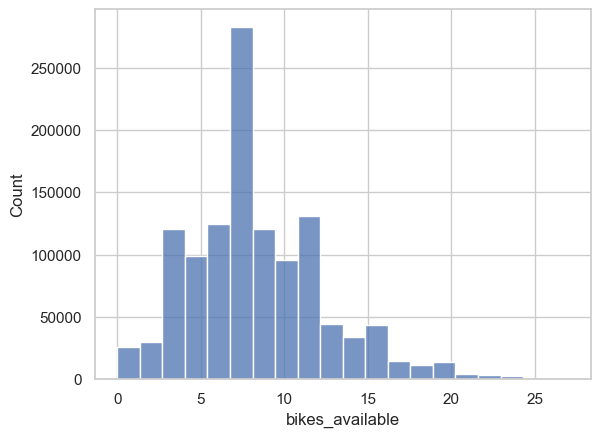

In [33]:
sns.histplot(status['bikes_available'], bins = 20)

2. intallation_date 기준으로 수요가 많은 지역 파악 및 수요가 많은 지역의 date 점검

In [12]:
station['installation_date'] = pd.to_datetime(station['installation_date'])
station[station['installation_date'].dt.year == 2014]['id'].unique() #82, 83, 84만 2014년 신설됨... #수요량 예측 파악해서 어느곳에 지으면 좋을지 

array([82, 83, 84])

4. 통계를 활용하여 급간을 세밀하게 조정하기 : 평균으로만 수요부족등을 판단하기에는 부족하다고 생각이 들었음